# Projet de mention

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## ε-greedy algorithm on a 10-arm bandit problem

In [ ]:
class Bandit:
    def __init__(self, k=10):
        self.k = k
        self.action_value = np.random.normal(0, 1, k)
    
    def pull(self, arm):
        return np.random.normal(self.action_value[arm], 1)
    
    def optimal_arm(self):
        return np.argmax(self.action_value)

class AgentEpsilonGreedy:
    def __init__(self, k=10, epsilon=0.1):
        self.k = k
        self.epsilon = epsilon
        self.estimated_action_value = np.zeros(k)
        self.action_count = np.zeros(k)
    
    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.k)
        else:
            return np.argmax(self.estimated_action_value)
    
    def update_values(self, arm, reward):
        self.estimated_action_value[arm] = (self.estimated_action_value[arm]*self.action_count[arm] + reward)/(self.action_count[arm]+1)
        self.action_count[arm] += 1

def simulate(bandit, agent, steps):
    rewards = np.zeros(steps)
    optimal_action = np.zeros(steps)
    optimal_arm = bandit.optimal_arm()
    for n in range(steps):
        arm = agent.select_action()
        reward = bandit.pull(arm)
        agent.update_values(arm, reward)
        rewards[n] = reward
        optimal_action[n] = arm == optimal_arm
    return rewards, optimal_action

n_simulation = 1000
steps = 1000
list_epsilon = np.array([0.01, 0.05, 0.1, 0.2])
all_rewards = np.zeros((n_simulation, steps, list_epsilon.size))
all_optimal_arm = np.zeros((n_simulation, steps, list_epsilon.size))
for i in range(list_epsilon.size):
    for k in range(n_simulation):
        agent = AgentEpsilonGreedy(epsilon=list_epsilon[i])
        bandit = Bandit()
        [all_rewards[k,:,i], all_optimal_arm[k,:,i]] = simulate(bandit,agent,steps)

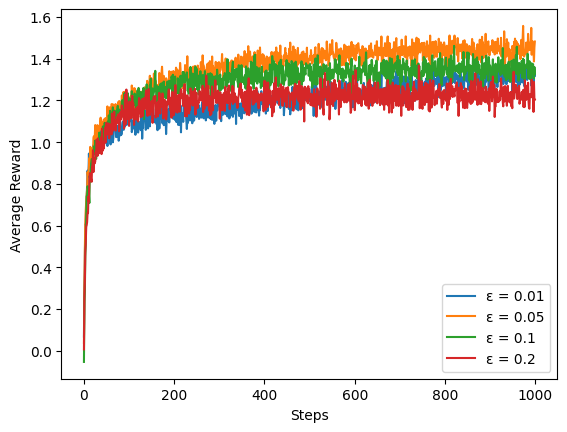

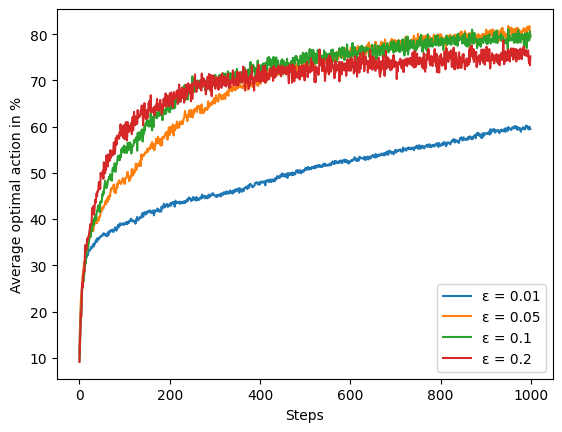

In [23]:
average_reward = all_rewards.mean(0)
for i, epsilon in enumerate(list_epsilon):
    plt.plot(average_reward[:, i], label=f'ε = {epsilon}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

average_optimal_arm = all_optimal_arm.mean(0)
for i, epsilon in enumerate(list_epsilon):
    plt.plot(average_optimal_arm[:, i]*100, label=f'ε = {epsilon}')
plt.xlabel('Steps')
plt.ylabel('Average optimal action in %')
plt.legend()
plt.show()